# Graphene Raman: 3-peak fitting of D, G and 2D

This is a fitting script for Raman spectra of graphene, to determine important characteristics like the ratio of the defect (D) peak to the graphite (G) peak or the symmetry of the the 2D peak.

## Graphene Raman peaks

The main graphene peaks are modeled as lmfit [Pseudo Voigt peaks](https://lmfit.github.io/lmfit-py/builtin_models.html#pseudovoigtmodel).

The script is aimed at a standard evaluation of these properties for multiple spectra, to obtain reasonable statistics.

In [1]:
#The default definition of peaks and ranges in the graphene spectrum
GRAPHENEPEAKS = [
    {
        #The name of the peak
        'prefix': 'D',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 1290.0, 'max': 1420.0},
        #constraints for the peak position
        'pos': {'min': 1340.0, 'center': 1350, 'max': 1360.0},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'center': 30.0, 'max': 40.0},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'center': 0.8, 'max': 1.0},
        #constraints for the peak height
        'amplitude': {'min': 0.0},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    },
    {
        #The name of the peak
        'prefix': 'G',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 1480.0, 'max': 1700.0},
        #constraints for the peak position
        'pos': {'min': 1560.0, 'center': 1585.0, 'max': 1610.0},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'center': 25.0, 'max': 50.0},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'center': 0.4, 'max': 1.0},
        #constraints for the peak height
        'amplitude': {'min': 0.0},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    },
    {
        #The name of the peak
        'prefix': 'Dplus',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 2350.0, 'max': 2540.0},
        #constraints for the peak position
        'pos': {'min': 2420.0, 'center': 2450.0, 'max': 2500.0},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'center': 25.0, 'max': 50.0},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'center': 0.4, 'max': 1.0},
        #constraints for the peak height
        'amplitude': {'min': 0.0},
        #If set to False, the peak will not be fitted, only initialized
        'vary': False
    },
    {
        #The name of the peak
        'prefix': 'twoD',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 2600.0, 'max': 2790.0},
        #constraints for the peak position
        'pos': {'min': 2650.0, 'center': 2670, 'max': 2750.0},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'center': 25.0, 'max': 80.0},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'center': 0.4, 'max': 1.0},
        #constraints for the peak height
        'amplitude': {'min': 0.0},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    }
]


The required packages are mostly part of the anaconda distribution. [lmfit](https://lmfit.github.io/lmfit-py/) is installed separately. Tested with Python 3.5.2 and lmfit 0.9.5

In [2]:
import numpy as np
from lmfit.models import PolynomialModel, PseudoVoigtModel
from lmfit.model import ModelResult
from lmfit import Parameters, report_fit
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import time
from copy import deepcopy
import tkinter as tk
from tkinter import filedialog

In [3]:
from lmfit._version import get_versions
print('Python version:', sys.version)
print('lmfit version:', get_versions()['version'])

Python version: 3.5.2 | packaged by conda-forge | (default, Jul 26 2016, 02:06:09) [MSC v.1900 64 bit (AMD64)]
lmfit version: 0.9.5


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Fitting task

Raman spectra of graphene are supplied in a text file, with the Ramanshift in cm<sup>-1</sup> and the intensity in separate columns. The resolution should be better than 1.5 cm<sup>-1</sup>, the range from at least from 1265 cm<sup>-1</sup> to 2810 cm<sup>-1</sup> for fitting of the default peaks.

The file can contain multiple datasets with an equal number of datapoints, each dataset is then individually processed and average values and histograms are generated.

Optionally, the data will be cut to the range specified by TASK['xmin'] and TASK['xmax'].

The default fitting uses separate fitting tasks with specific baseline subtraction for the D + G band and the 2D band. In general this leads to more robust results.

In [5]:
TASK = {
    #Filename as full path. The file can contain multiple datasets with an equal number of datapoints
    #'filename': 'examples/CVD_graphene_example.txt',  #optional
    
    #If filename is left unspecified a file dialog will open in:
    'initialDir': './',
    
    #Columns in the file to be used
    'posx_column': 0,  #optional
    'posy_column': 1,  #optional
    'ramanshift_column': 2,
    'ramanintensity_column': 3,
    
    #Set to the number of polynomial for baseline subtraction, 0 for no baseline
    #Maxium allowed value is 7
    'baselineOrder': 6,
    
    #Minimum signal-to-noise ratio, if 0 all speactra are used
    'snr': 5000,
    
    #The minimum number of remaining spectra after signal-to-noise selection 
    'minimumStatisctics': 10,
    
    #Minium x value
    'xmin': 1200.0,  #optional
    #Maximum x value
    'xmax': 2810.0,  #optional
    
    #Dictionary where the peaks are defined
    'peaks': deepcopy(GRAPHENEPEAKS)
}

"""Partially defined polynomial baseline"""
BASELINE = [
    {
        #partial baseline is defined
        'untilX': 1750.0,  #in wavenumbers
        #and has
        'polynomialOrder': 2,
        #and requires minimum signal-to-noise ratio
        'snr': 500  #which can be 0 to include all spectra
    },
    {
        'untilX': 2555.0,
        'polynomialOrder': 4,
        'snr': 0
    },
    {
        'untilX': 2810.0,
        'polynomialOrder': 1,
        'snr': 500
    }
]

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 16})

In [7]:
from IPython.display import Markdown, display
#we want to use markdown in the output of cells
def printmd(string):
    display(Markdown(string))

## Datasets

The datasets are read from a text file in the same folder as the notebook, using TASK['filename'] with x and y columns defined in TASK['ramanshift_column'] and TASK['ramanintensity_column']. 

## Weights arrays

Here we generate weights arrays, one for each peak and one for the baseline. For each peak the weight is zero except in the range defined in the peak dictionary.

The baseline has weight 1 everywhere except in the peak ranges, where it is set to zero. Like that, the baseline fit ignores the peak ranges.

## Baseline subtraction

A polynomial baseline of the order defined in TASK['baselineorder'] is subtracted from every dataset.


Datasets are omitted if the signal to noise ratio is lower than the value defined in TASK['snr']. This is recommended, because for low signal spectra the evaluation is not reliable. The signal to noise ratio is determined by the squared variance of the data divided by the squared variance of the data points excluding the peak ranges.

In [8]:
class Dataset:
    def __init__(self, task=None):
        self.weights = {}
        self.task = task
        
        if task.get('filename') is None:
            task['filename'] = self.getFilename(initialDir=task.get('initialDir'))
        
        self.data, self.numberOfDatasets = self.readDatasets(self.task)
        self.datasetX, self.datasetY, self.posX, self.posY = self.prepareDatasets(self.data, self.task)
        
        self.setWeights(self.task.get('peaks'))
        
    def getFilename(self, initialDir=None):
        
        if initialDir is None:
            initialDir = './'
        filename = filedialog.askopenfilename(
            initialdir=initialDir,
            filetypes=[('Raman text files', '*.txt')]
        )
        
        root = tk.Tk()
        root.withdraw()
        
        return filename
    
    def readDatasets(self, task):
        
        print('Reading ', task['filename'], flush=True)

        usecols = [
            task['ramanshift_column'],
            task['ramanintensity_column']
        ]

        if not task.get('posx_column') is None and not task.get('posy_column') is None:
            usecols.append(task['posx_column'])
            usecols.append(task['posy_column'])

        #if bool(task.get('posx_') and pos
        data = np.loadtxt(task['filename'], usecols=usecols)

        print('Data ', task['filename'], ' read', flush=True)

        #if data are in descending order, reverse
        if data[1,0] < data[0,0]:
            data[:] = data[::-1]

        print('Data reversed', flush=True)

        #detect a new dataset if x value smaller than preceding xval
        number_of_datasets = 1
        xval = data[0,0]
        for nextx in data[:,0]:
            if nextx < xval:
                number_of_datasets += 1
            xval = nextx

        print(str(number_of_datasets), ' datasets detected', flush=True)

        return (data, number_of_datasets)


    def prepareDatasets(self, data, task):
        """Build x, y and position arrays
        
        Cuts the dataset to the range specified in the task.
        If necessary, brings the data in ascending-x order
        Args:
            data (numpy.array): Data from readDatasets
            task (dict): Task object defining xmin and xmax
        Returns:
            tuple: tuple of 2D numpy arrays for x, y, [posX, and posY]
        """
        
        #xmax and xmin are optional in the task dict
        if (not task.get('xmax') is None and
            not task.get('xmin') is None):

            mask = np.ones(len(data), dtype=bool)

            mask = np.where(
                ((data[:,0] > task['xmin']) &
                (data[:,0] < task['xmax'])),
                True,
                False
            )
            data = data[mask,...]
            print('Data cut: ', task['xmin'], task['xmax'], flush=True)

        task['datasetsLoaded'] = self.numberOfDatasets
        
        x = np.reshape(data[:,0], (task['datasetsLoaded'], -1))
        y = np.reshape(data[:,1], (task['datasetsLoaded'], -1))

        print('Data reshaped', flush=True)

        if not task.get('posx_column') is None and not task.get('posy_column') is None:
            posx = np.reshape(data[:,2], (task['datasetsLoaded'], -1))
            posy = np.reshape(data[:,3], (task['datasetsLoaded'], -1))
            #posx = posx[np.array([True]),...]
            #posy = posy[np.array([True]),...]
        else:
            posx = None
            posy = None

        return (x, y, posx, posy)
    
    
    def setWeights(self, peaks):
        """Set weights arrays
        Here we generate weights arrays, one for each peak and one for the baseline.
        For each peak, the weight is zero except in the range defined in the peak dictionary.
        The baseline has weight 1 everywhere except in the peak ranges, where it is set to zero.
        Like that, the baseline fit ignores the peak ranges.
        
        Args:
            peaks (dict): a list of peaks
        """
        x = self.datasetX[0,:]

        weightsBaseline = np.ones_like(x)

        for peak in peaks:
            weightsPeak = np.where(
                ((x > peak['range']['min']) &
                (x < peak['range']['max'])),
                1.0,
                0.0
            )
            weightsBaseline = np.where(
                ((x > peak['range']['min']) &
                (x < peak['range']['max'])),
                0.0,
                weightsBaseline
            )

            self.weights[peak['prefix']] = weightsPeak

        self.weights['baseline'] = weightsBaseline
        self.weights['peaks'] = 1 - weightsBaseline
        self.weights['included'] = np.ones_like(self.datasetX[:,0])


        print('Weights arrays initialized', flush=True)
        
    
    def subtractBaseline(self, exampleSpec=None, baselinePart=None, mask=None):
        """Subtracts a partially defined polynomial baseline
        
        Args:
            exampleSpec (int): index of an example spectrum to be plotted.
                If this is None, no output will be plotted.
            baselinePart (dict): includes 'polynomialOrder'
            mask (numpy.array): a boolean array of the shape like datasetX.
                Only the part where True will be baseline corrected.
        """
        if any(dim < 1 for dim in np.shape(self.datasetX)):
            return

        cutDatasetX = self.datasetX[:,mask,...]
        cutDatasetY = self.datasetY[:,mask,...]
        cutBaselineweights = self.weights['baseline'][mask,...]

        if not baselinePart is None:
            baselineOrder = baselinePart['polynomialOrder']
            minSnr = baselinePart.get('snr')
        else:
            baselineOrder = self.task.get('baselineOrder')
            if baselineOrder is None or baselineOrder < 1:
                baselineOrder = 1
            checkSnr = True
            minSnr = self.task.get('snr')

        if minSnr is None:
            minSnr = 0

        if baselineOrder is None or baselineOrder < 1:
            correctData = False
            baselineOrder = 6
        else:
            correctData = True

        snrFilter = np.ones_like(cutDatasetX[:,0], dtype=bool)

        snrs = np.zeros_like(cutDatasetX[:,0])


        parameters = Parameters()
        mod = PolynomialModel(baselineOrder, prefix='background_')
        parameters.update(mod.guess(cutDatasetY[0,:], x=cutDatasetX[0,:]))


        for i, dataX in enumerate(cutDatasetX):

            try:
                modResult = mod.fit(cutDatasetY[i,:], parameters, x=cutDatasetX[i,:], weights=cutBaselineweights)

                baseline = mod.eval(modResult.params, x=cutDatasetX[i,:])

                if not exampleSpec == None and i == exampleSpec:
                    exampleBaselineData = mod.eval(modResult.params, x=cutDatasetX[i,:])
                    exampleResiduals = modResult.residual

                if correctData:
                    self.datasetY[i,mask,...] = cutDatasetY[i,:] - baseline

                #calc signal to noise - note that residuals exclude the peak area
                snr = np.var(cutDatasetY[i,:])**2 / np.var(modResult.residual)**2

                if snr != snr:
                    snr = 0

                snrs[i] = snr

                if snr < minSnr:
                    snrFilter[i] = False                        

            except Exception as err:
                print(err)
                snrFilter[i] = False
            self.weights['included'] = np.logical_and(self.weights['included'], snrFilter)

        #plot output only if exampleSpec is set
        if not exampleSpec is None:

            printmd('## Example baseline')
            baselineFig = plt.figure()
            baselineFig.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=-0.3)
            baselineFig.set_figheight(18)

            exampleBaseline = baselineFig.add_subplot(421)
            exampleBaseline.set_title('Example baseline Nr. %d' % exampleSpec)
            exampleResidual = baselineFig.add_subplot(422)
            exampleResidual.set_title('Example residual Nr. %d' % exampleSpec)

            exampleBaseline.plot(cutDatasetX[exampleSpec, :], cutDatasetY[exampleSpec, :], 'r--')
            exampleBaseline.plot(cutDatasetX[exampleSpec, :], exampleBaselineData)
            #exampleBaseline.set_xlabel('Raman shift (cm-1)')
            exampleBaseline.set_ylabel('Intensity (arb. units)')

            exampleResidual.plot(cutDatasetX[exampleSpec, :], exampleResiduals)
            #exampleResidual.set_xlabel('Raman shift (cm-1)')
            exampleResidual.set_ylabel('Intensity (arb. units)')


            includedNumber = np.sum(snrFilter)
            excludedNumber = len(snrFilter) - includedNumber

            #if minSnr > 0 and (0 < np.sum(snrFilter) < len(snrFilter)):
            if minSnr > 0 and excludedNumber > 0:

                exampleExcluded = baselineFig.add_subplot(423)
                exampleExcluded.set_title('Examples from %d excluded spectra' % excludedNumber)

                exampleIncluded = baselineFig.add_subplot(424)
                exampleIncluded.set_title('Example included spectra')

                exclInclInds = np.argsort(snrs)

                maxPlots = 5
                includedPlotted = 0
                excludedPlotted = 0
                firstExcludedSpec = 0

                for i, ind in enumerate(exclInclInds):
                    if snrFilter[ind] == True:
                        atSnr = i
                        firstExcludedSpec = i - min(excludedNumber, maxPlots)
                        firstExcludedSpec = max(0, firstExcludedSpec)
                        firstIncludedSpec = i + min(maxPlots, includedNumber)
                        firstIncludedSpec = max(firstIncludedSpec, len(self.datasetX[:,0]) - 1)
                        break

                for ind in exclInclInds[firstExcludedSpec:atSnr]:
                    exampleExcluded.plot(self.datasetX[ind,mask,...], self.datasetY[ind,mask,...])

                for ind in exclInclInds[atSnr:firstIncludedSpec]:
                    exampleIncluded.plot(self.datasetX[ind,mask,...], self.datasetY[ind,mask,...])

                exampleExcluded.set_ylabel('Intensity (arb. units)')
                exampleIncluded.set_xlabel('Raman shift (cm-1)')
                exampleIncluded.set_ylabel('Intensity (arb. units)')

                plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
                plt.show()

                plt.hist(snrs)
                plt.xlabel('Signal to noise ratio')
                plt.ylabel('#')

            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
            plt.show()
            printmd('## Example for corrected spectrum')
            plt.title('Example baseline corrected spectrum Nr. %d' % exampleSpec)
            plt.plot(self.datasetX[exampleSpec, :], self.datasetY[exampleSpec, :])
            plt.xlabel('Raman shift (cm-1)')
            plt.ylabel('Intensity (arb. units)')
            plt.show()


    def filterDatasetBySNR(self, exampleSpec=None):
        """Filters out data with too low SNR
            Applies the filter of self.weights['included'] to the dataset.
            
            Args:
                exampleSpec (int): index of an example spectrum to be plotted
        """
        
        mask = self.weights.get('included')

        if (not (mask is None) and
            len(mask) - np.sum(mask) > 0):

            print('%d spectra were excluded from %d datasets' %
                  (len(mask) - np.sum(mask), self.task['datasetsLoaded']))

            x = self.datasetX[mask,...]
            y = self.datasetY[mask,...]
        else:
            print('%d spectra were excluded from %d datasets' % (0, self.task['datasetsLoaded']))

            x = self.datasetX
            y = self.datasetY


        if len(x[:, 0]) < self.task['minimumStatisctics']:
            raise UserWarning((
                'The mimimum size of %d spectra'  % self.task['minimumStatisctics'] +
                ' with a high enough signal-to-noise' +
                ' level has not been reached.' +
                ' You can change the \'minimumStatisctics\' in the task,' +
                ' the evaluation will then not any more correspond to the standard.'))

        else:
            print('%d datasets left for fitting' % len(x[:, 0]))
            self.task['datasetsFitted'] = len(x[:, 0])
            
        self.datasetX = x
        self.datasetY = y
        

    #instead of a single baseline, a partially defined polynomial baseline can be used
    def subtractMultiBaseline(self, baselineParts=None, exampleSpec=None):

        lastXBoundary = self.datasetX[0,0]

        for i, baselinePart in enumerate(baselineParts):

            baselineMask = np.where(((self.datasetX[0,:] < baselinePart.get('untilX')) &
                (self.datasetX[0,:] >= lastXBoundary)),
                True,
                False
            )

            self.subtractBaseline(
                exampleSpec=exampleSpec,
                baselinePart=baselinePart,
                mask=baselineMask)

            lastXBoundary = baselinePart.get('untilX')

## Multi-peak model

Reads the peaks defined in TASK['peaks'] and builds and lmfit CompositeModel from them.

With the runFit method, a fitting of all datasets can be started.


In [9]:
class MultiPseudoVoigtModel:
    
    def __init__(self, dataset, weights=None):
        self.peaks = dataset.task.get('peaks')
        
        self.datasetX = dataset.datasetX
        self.datasetY = dataset.datasetY
        
        self.startTime = time.time(),
        self.weights = weights
        
        self.fitResults = np.zeros_like(self.datasetX[:,0], dtype=object)
        self.parameters = Parameters()
        if len(self.datasetX) > 0:
            self.makeModel()
        
    def makePeak(self, peak):
        
        prefix = peak['prefix'] + '_'
        peakMod = PseudoVoigtModel(prefix=prefix)
        self.parameters.update(
            peakMod.guess(self.datasetY[0,:], x=self.datasetX[0,:]))
        
        self.parameters[prefix + 'center'].set(
            peak.get('pos', {}).get('center'),
            min=peak.get('pos', {}).get('min'),
            max=peak.get('pos', {}).get('max')
        )
        self.parameters[prefix + 'sigma'].set(
            peak.get('sigma', {}).get('center'),
            min=peak.get('sigma', {}).get('min'),
            max=peak.get('sigma', {}).get('max')
        )
        self.parameters[prefix + 'amplitude'].set(
            peak.get('amplitude', {}).get('center'),
            min=peak.get('amplitude', {}).get('min'),
            max=peak.get('amplitude', {}).get('max')
        )
        self.parameters[prefix + 'fraction'].set(
            peak.get('fraction', {}).get('center'),
            min=peak.get('fraction', {}).get('min'),
            max=peak.get('fraction', {}).get('max'),
            vary=True,
            expr=None
        )
        
        #the lmfit PseudoVoigt model does not have a height
        #add this as fixed parameter
        self.parameters.add(
            prefix + 'height',
            value=100,
            vary=False,
            expr='%samplitude / %sfwhm' % (prefix, prefix)
        )
        return peakMod
    
    
    def makeModel(self):
        peaksIncluded = 0
        
        for i, peak in enumerate(self.peaks):
            peakMod = self.makePeak(peak)
            
            if peak['vary'] == True:
                if peaksIncluded == 0:
                    self.model = peakMod
                    peaksIncluded += 1
                else:
                    self.model = self.model + peakMod
                    peaksIncluded += 1
    
    
    def runFit(self, maxNumber=None):
        self.startTime = time.time()
        print('--- Fitting datasets started ',
              time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime()),
              flush=True)
        
        for i, ydata in enumerate(self.datasetY):
 
            if not maxNumber is None and i > maxNumber:
                break

            try:
                modResult = self.model.fit(
                    self.datasetY[i,:],
                    self.parameters,
                    x=self.datasetX[i,:],
                    method='leastsq',
                    weights=self.weights
                )

                self.fitResults[i] = modResult
                
            except Exception as err:
                print(err)
                #self.excludedDatasets.append(i)

        print("--- Fit completed in %s seconds ---" % (time.time() - self.startTime))
    

## Graphene fit results

This class takes the standard fit results from lmfit and provides graphene specific evaluations.

In [10]:
class FitResultParameter:
    def __init__(self, datasets):
        self.values = np.ma.masked_array(np.ones_like(datasets))
        #self.maskedValues = self.values
        self.avg = 0
        self.dev = 0
        self.outliersMin = np.ones_like(datasets, dtype=int)
        self.outliersMax = np.ones_like(datasets, dtype=int)
    def calcAvg(self):
        self.avg = np.ma.average(self.values)
        self.dev = np.ma.std(self.values)
    def getStr(self):
        return '%.3f +/- %.3f' % (self.avg, self.dev)
    def setMask(self, lower, upper):
        self.values = np.ma.masked_outside(self.values, lower, upper)
        #self.values.fill_value = np.nan
    def setOutliers(self, howMany):
        
        if howMany > len(self.values) + 1:
            howMany = len(self.values) - 1
        self.outliersMin = np.ma.masked_array.argpartition(
            np.ma.filled(self.values, self.avg), howMany)[:(howMany)]
        
        self.outliersMax = np.ma.masked_array.argpartition(
            np.ma.filled(self.values, self.avg), -howMany)[-(howMany):]
        
        
class GrapheneModelResults:
    def __init__(self, modResults, dataset):
        self.fitResults = modResults
        self.x = dataset.datasetX
        self.y = dataset.datasetY
        self.posX = dataset.posX
        self.posY = dataset.posY
        self.weights = dataset.weights
        
        self.datasetsNumber = len(self.x)
        
        self.task = dataset.task
        self.baseFilename = self.task['filename'].replace('.txt', '')
        
        self.DtoG_area = FitResultParameter(self.x[:,0])
        self.DtoG_height = FitResultParameter(self.x[:,0])
        self.twoDtoG_area = FitResultParameter(self.x[:,0])
        
        
        self.widthD = FitResultParameter(self.x[:,0])
        self.widthG = FitResultParameter(self.x[:,0])
        self.widthtwoD = FitResultParameter(self.x[:,0])
        
        self.widthD = FitResultParameter(self.x[:,0])
        self.widthG = FitResultParameter(self.x[:,0])
        self.centertwoD = FitResultParameter(self.x[:,0])
        
        self.areaG = FitResultParameter(self.x[:,0])
        
        self.twoDmaxRes = FitResultParameter(self.x[:,0])
        self.twoDr2 = FitResultParameter(self.x[:,0])
        
        self.calcPeakRatios()
    
    def calcPeakRatios(self):
        if self.datasetsNumber < 1:
            return
        if self.fitResults[0].params.get('G_amplitude') is None:
            return
        
        for i, modResult in enumerate(self.fitResults):
            
            self.DtoG_area.values[i] = (
                modResult.params['D_amplitude'] /
                modResult.params['G_amplitude'])
            
            self.DtoG_height.values[i] = (
                modResult.params['D_height'] /
                modResult.params['G_height'])
            
            self.twoDtoG_area.values[i] = (
                modResult.params['twoD_amplitude'] /
                modResult.params['G_amplitude'])
            
            
            self.widthD.values[i] = (modResult.params['D_fwhm'])
            self.widthG.values[i] = (modResult.params['G_fwhm'])
            self.widthtwoD.values[i] = (modResult.params['twoD_fwhm'])
            self.centertwoD.values[i] = (modResult.params['twoD_center'])
            
            self.areaG.values[i] = (modResult.params['G_amplitude'])
        
        self.DtoG_area.setMask(0.01, 5)
        self.DtoG_height.setMask(0.01, 5)
        self.DtoG_area.calcAvg()
        self.DtoG_area.setOutliers(5)
        self.DtoG_height.calcAvg()
        self.DtoG_height.setOutliers(5)
        self.twoDtoG_area.calcAvg()
        self.widthD.calcAvg()
        self.widthG.calcAvg()
        self.widthtwoD.calcAvg()
        self.centertwoD.calcAvg()
        self.areaG.calcAvg()
    
    def writeOutput(self, filenameAd):
        if self.datasetsNumber < 1:
            return
        
        out = np.ndarray((len(self.x[:,0]), 19))
        header = ''
        delimiter = ';'
        
        fittedD =  self.fitResults[0].best_values.get('D_center') != None
        fittedG =  self.fitResults[0].best_values.get('G_center') != None
        
        fittedtwoD =  self.fitResults[0].best_values.get('twoD_center') != None
        
        for i, xdata in enumerate(self.x[:,0]):
            j = 0
            if i == 0: header += 'Position x'
            out[i][j] = self.posX[i,0]
            j += 1
            if i == 0: header += delimiter + 'Position y'
            out[i][j] = self.posY[i,0]
            
            if fittedD:
                j += 1
                if i == 0: header += delimiter + 'D center'
                out[i][j] = self.fitResults[i].params['D_center']
                j += 1
                if i == 0: header += delimiter + 'D area'
                out[i][j] = self.fitResults[i].params['D_amplitude']
                j += 1
                if i == 0: header += delimiter + 'D FWHM'
                out[i][j] = self.fitResults[i].params['D_fwhm']
                j += 1
                if i == 0: header += delimiter + 'D fraction'
                out[i][j] = self.fitResults[i].params['D_fraction']
                
            if fittedG:
            
                j += 1
                if i == 0: header += delimiter + 'G center'
                out[i][j] = self.fitResults[i].params['G_center']
                j += 1
                if i == 0: header += delimiter + 'G area'
                out[i][j] = self.fitResults[i].params['G_amplitude']
                j += 1
                if i == 0: header += delimiter + 'G FWHM'
                out[i][j] = self.fitResults[i].params['G_fwhm']
                j += 1
                if i == 0: header += delimiter + 'G fraction'
                out[i][j] = self.fitResults[i].params['G_fraction']
            
            if fittedtwoD:
                j += 1
                if i == 0: header += delimiter + '2D center'
                out[i][j] = self.fitResults[i].params['twoD_center']
                j += 1
                if i == 0: header += delimiter + '2D area'
                out[i][j] = self.fitResults[i].params['twoD_amplitude']
                j += 1
                if i == 0: header += delimiter + '2D FWHM'
                out[i][j] = self.fitResults[i].params['twoD_fwhm']
                j += 1
                if i == 0: header += delimiter + '2D fraction'
                out[i][j] = self.fitResults[i].params['twoD_fraction']
            
            if fittedD:
                if fittedG:
                    j += 1
                    if i == 0: header += delimiter + 'D/G (area)'
                    out[i][j] = self.DtoG_area.values[i]
                    j += 1
                    if i == 0: header += delimiter + 'D/G (height)'
                    out[i][j] = self.DtoG_height.values[i]
                
                if fittedtwoD:
                    j += 1
                    if i == 0: header += delimiter + '2D/G'
                    out[i][j] = self.twoDtoG_area.values[i]
            if fittedtwoD:
                j += 1
                if i == 0: header += delimiter + '2D NSR'
                out[i][j] = self.twoDmaxRes.values[i]
                j += 1
                if i == 0: header += delimiter + '2D R2'
                out[i][j] = self.twoDr2.values[i]
            
        j += 1
        out.resize(i,j)
        
        header += delimiter + str(self.task)
        filename = self.baseFilename + '_' + filenameAd + '.csv'
        np.savetxt(filename, out, delimiter=delimiter, header=header)
        print('Evaluation saved as: ', filename)    
        
    def printAvgRes(self):
        if self.datasetsNumber < 1:
            return
        out = str(self.DtoG_area.avg)
        out += ' ' + str(self.DtoG_area.dev)
        
        out += ' ' + str(self.twoDr2.avg)
        out += ' ' + str(self.twoDr2.dev)
        
        out += ' ' + str(self.twoDtoG_area.avg)
        out += ' ' + str(self.twoDtoG_area.dev)
        
        out += ' ' + str(self.widthG.avg)
        out += ' ' + str(self.widthG.dev)
        
        out += ' ' + str(self.widthtwoD.avg)
        out += ' ' + str(self.widthtwoD.dev)
        
        out += ' ' + str(self.areaG.avg)
        out += ' ' + str(self.areaG.dev)
        
        print(out)
  
    def printDtoG(self):
        print('D/G ratio by area: ', self.DtoG_area.getStr())
        print('D/G ratio by height: ', self.DtoG_height.getStr())
    
    def printtwoDtoG(self):
        if self.fitResults[0].best_values.get('twoD_center') != None:
            print('2D/G ratio by area: ', self.twoDtoG_area.avg, ' +/- ', self.twoDtoG_area.dev)
    
    def printWidths(self):
        if self.fitResults[0].best_values.get('D_center') != None:
            print('D width: ', self.widthD.avg, ' +/- ', self.widthD.dev)
        if self.fitResults[0].best_values.get('G_center') != None:    
            print('G width: ', self.widthG.avg, ' +/- ', self.widthG.dev)
        
        if self.fitResults[0].best_values.get('twoD_center') != None:
            print('2D width: ', self.widthtwoD.avg, ' +/- ', self.widthtwoD.dev)
        
    def plotWidths(self):
        self.histFrom(self.widthD.values, 'D FWHM (cm-1)')
        self.histFrom(self.widthG.values, 'G FWHM (cm-1)')
        self.histFrom(self.widthtwoD.values, '2D FWHM (cm-1)')
    
    def histFrom(self, values, xlabel, saveName=None, bins=None):
        if not bins is None:
            plt.hist(values, bins=bins)
        else:
            plt.hist(values)
        plt.xlabel(xlabel)
        plt.ylabel('#')
        if not saveName is None:
            plt.savefig(self.baseFilename + saveName + '.png', dpi=300)
        plt.show()
    
    def histDtoGArea(self, save=None):
        
        if not save is None and save == True:
            saveName = '_DtoG-hist'
        else:
            saveName = None
        
        self.histFrom(
            self.DtoG_area.values,
            'D/G',
            bins=np.linspace(0, 2, 41),
            saveName=saveName
        )
    
    def histCentertwoD(self):
        self.histFrom(self.centertwoD.values, 'Center of 2D peak')
    
    def histtwoDtoGArea(self):
        if self.fitResults[0].best_values.get('twoD_center') != None:
            self.histFrom(self.twoDtoG_area.values, '2D/G')
    
    def printPeakRatios(self, save=None):
        if self.datasetsNumber < 1:
            return
        self.printDtoG()
        self.histDtoGArea(save)
        
        self.printtwoDtoG()
        self.histtwoDtoGArea()
    
    def plotRes(self, resultNumber):
        if self.datasetsNumber < resultNumber:
            return
        plt.plot(self.x[resultNumber, :], self.fitResults[resultNumber].best_fit, 'r-')
        plt.plot(self.x[resultNumber, :], self.y[resultNumber, :])
        plt.xlabel('Raman shift (cm-1)')
        plt.ylabel('Intensity (arb. units)')

    def plotDG(self, resultNumber):
        if self.datasetsNumber < resultNumber:
            return
        self.plotRes(resultNumber)
        plt.xlim(1250, 1650)
        plt.show()
        
    def plotFit(self, resultNumber):
        if self.datasetsNumber < 1:
            return
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        
        ax1.plot(self.x[resultNumber, :], self.fitResults[resultNumber].best_fit, 'r-')
        ax1.plot(self.x[resultNumber, :], self.y[resultNumber, :], 'ko', markersize=2)
        start, end = ax1.get_xlim()
        ax1.xaxis.set_ticks(np.arange(start, end, 100.0))
        
        ax2.plot(self.x[resultNumber, :], self.fitResults[resultNumber].best_fit, 'r-')
        ax2.plot(self.x[resultNumber, :], self.y[resultNumber, :], 'ko', markersize=2)
        start, end = ax2.get_xlim()
        ax2.xaxis.set_ticks(np.arange(start, end, 100.0))
        
        ax1.set_ylabel('Intensity (arb. units)')
        ax1.set_xlim([1250, 1650])
        ax2.set_xlim([2550, 2820])
        ax1.set_xlabel('Raman shift (cm-1)')
        ax2.set_xlabel('Raman shift (cm-1)')
        plt.show()

    def plot2D(self, resultNumber, save=None):
        self.plotRes(resultNumber)
        plt.figtext(0.2, 0.8,
             'NSR: ' + str('{0:.2f}'.format(self.twoDmaxRes.values[resultNumber]))
        )
        
        plt.xlim(2550, 2800)
        
        if not save is None and save == True:
            plt.savefig('2DpeakRes' + str(resultNumber) + '.png')
        
        plt.show()
    
    
    def get2Dresiduals(self, evalRange=None, plot=None):
        if self.datasetsNumber < 1:
            return
        if self.fitResults[0].params.get('twoD_center') is None:
            return
        
        #helper to get the running mean of a spectrum
        def running_mean(ydata, width):
            cumsum = np.cumsum(np.insert(ydata, 0, 0)) 
            return (cumsum[width:] - cumsum[:-width]) / width
            
            
        for i, modResult in enumerate(self.fitResults):
            
            #we use the range for the 2D peak defined in self.task['peaks']
            twoDresRange = self.weights['twoD'] == 1
            
            twoDres = self.fitResults[i].residual[twoDresRange,...]
            ydata = self.y[i,:][twoDresRange,...]
            
            #the coefficient of determination is calculated from smoothed residuals
            #to reduce the impact of detector noise on the value
            #we are only interested in the symmetry of the peak
            r2 = 1 - np.var(running_mean(twoDres, 5)) / np.var(running_mean(ydata, 5))
            
            self.twoDr2.values[i] = r2
            
            twoDres = twoDres**2 / (
                self.fitResults[i].params['twoD_height'])**2
            
            self.twoDmaxRes.values[i] = (max(twoDres))
            if not plot is None and plot == True: 
                plt.plot(running_mean(twoDres, 5))
        
        self.twoDr2.setMask(0.0, 1)
        self.twoDmaxRes.setOutliers(5)
        self.twoDr2.setOutliers(5)
        
        if not plot is None and plot == True:
            plt.ylabel('Normalized squared residuals')
            plt.xlabel('Number of evaluated 2D data points')
            plt.show()
            
        self.twoDmaxRes.calcAvg()
        self.twoDr2.calcAvg()
        
    def get2DresIntervals(self, thres):
        return (100 * (self.twoDmaxRes.values < thres).sum() /
                self.twoDmaxRes.values.count()
            )
    
    def get2Dr2Intervals(self, thres):
        return (100 * (self.twoDr2.values > thres).sum() /
                self.twoDr2.values.count()
            )
    
    def getDtoGIntervals(self, thres):
        return (100 * (self.DtoG_area.values < thres).sum() /
                self.DtoG_area.values.count()
            )
    
    def print2DresIntervals(self, thres):
        print('Symmetric 2D shapes (NSR < %s): %.2f' % (thres,
            self.get2DresIntervals(thres)),
              ' %'
        )
    
    def print2Dr2Intervals(self, thres):
        print('Symmetric 2D shapes (R2 > %s): %.2f' % (thres,
            self.get2Dr2Intervals(thres)),
              ' %'
        )
    
    def printDtoGIntervals(self, thres):
        print('D/G < %s): %.2f' % (thres,
            self.getDtoGIntervals(thres)),
              ' %'
        )
        
    def print2Dr2(self, save=None):   
        printmd('### 2D peak R2: ' + 
             self.twoDr2.getStr())
        
        
        if not save is None and save == True:
            saveName = '_R2-hist'
        else:
            saveName = None
            
        self.histFrom(
            self.twoDr2.values,
            'Coefficient of determination R2',
            bins=np.linspace(0.9, 1, 51),
            saveName=saveName
        )
    
    def print2Dresiduals(self, save=None): 
        printmd('### Maximum normalized residual of 2D peak fit: ' +
             self.twoDmaxRes.getStr())
        
        if not save is None and save == True:
            saveName = '_NSR-hist'
        else:
            saveName = None
        
        self.histFrom(
            self.twoDmaxRes.values,
            'Normalized squared residual',
            bins=np.linspace(0, 0.1, 51),
            saveName=saveName
        )
    
    def plot2DOutliers(self, outlierNumber, save=None):
        if self.datasetsNumber < 1:
            return
        
        outliersFig = plt.figure()
        #outliersFig.subplots_adjust(left=-0.1, right=0.9, top=1.0, bottom=-0.3, hspace=0.2, wspace=.001)
        outliersFig.set_figheight(outlierNumber * 6)
        
        def makeSubPlot(fromIndices, col):
            for i, index in enumerate(fromIndices):
                if i < outlierNumber:
                    outlier = outliersFig.add_subplot(outlierNumber, 2, 2 * i + col)
                    outlier.plot(self.x[index, :], self.fitResults[index].best_fit, 'r-')
                    outlier.plot(self.x[index, :], self.y[index, :])
                    if i >=  outlierNumber - 1:   
                        outlier.set_xlabel('Raman shift (cm-1)')
                    if col == 1:
                        outlier.set_ylabel('Intensity (arb. units)')
                    #plt.tick_params(
                    #    axis='y',
                    #    which='both',
                    #    left='off',
                    #    right='off',
                    #    labelleft='off'
                    #)
                    outlier.set_title(
                        'Spec. ' + str(index) +
                        ', R2: %.3f' % self.twoDr2.values[index]
                    )
                    outlier.set_xlim(2550, 2800)

        
        makeSubPlot(self.twoDr2.outliersMin, 1)
        makeSubPlot(self.twoDr2.outliersMax, 2)
        
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
       
        if not save is None and save == True:
            outliersFig.savefig(self.baseFilename + '_2DpeakR2.png', dpi=300)
    
        plt.show()
        
    def plotDtoGOutliers(self, outlierNumber, save=None):
        if self.datasetsNumber < 1:
            return
        
        outliersFig = plt.figure()
        #outliersFig.subplots_adjust(left=-0.1, right=0.9, top=1.0, bottom=-0.3, hspace=0.2, wspace=.001)
        outliersFig.set_figheight(outlierNumber * 6)
        
        def makeSubPlot(fromIndices, col):
            for i, index in enumerate(fromIndices):
                if i < outlierNumber:
                    outlier = outliersFig.add_subplot(outlierNumber, 2, 2 * i + col)
                    outlier.plot(self.x[index, :], self.fitResults[index].best_fit, 'r-')
                    outlier.plot(self.x[index, :], self.y[index, :])
                    if i >=  outlierNumber - 1:   
                        outlier.set_xlabel('Raman shift (cm-1)')
                    if col == 1:
                        outlier.set_ylabel('Intensity (arb. units)')
                    #plt.tick_params(
                    #    axis='y',
                    #    which='both',
                    #    left='off',
                    #    right='off',
                    #    labelleft='off'
                    #)
                    outlier.set_title(
                        'Spec. ' + str(index) +
                        ', D/G: %.2f' % self.DtoG_area.values[index]
                    )
                    outlier.set_xlim(1250, 1750)

        
        makeSubPlot(self.DtoG_area.outliersMin, 1)
        makeSubPlot(self.DtoG_area.outliersMax, 2)
        
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
       
        if not save is None and save == True:
            outliersFig.savefig(self.baseFilename + '_DtoG.png', dpi=300)
    
        plt.show()
    

## 2D peak fitting

Here starts the actual data processing.

Reading  C:/Users/hoffmann/Tempo Box/jupyter/raman/examples/CVD_graphene_example.txt
Data  C:/Users/hoffmann/Tempo Box/jupyter/raman/examples/CVD_graphene_example.txt  read
Data reversed
121  datasets detected
Data cut:  1200.0 2810.0
Data reshaped
Weights arrays initialized


## Example baseline

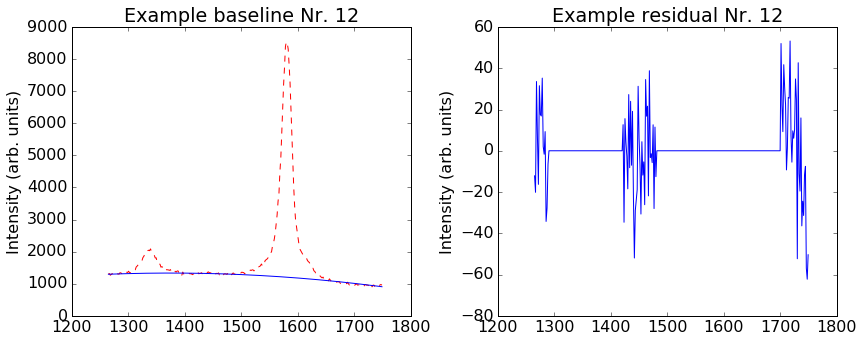

## Example for corrected spectrum

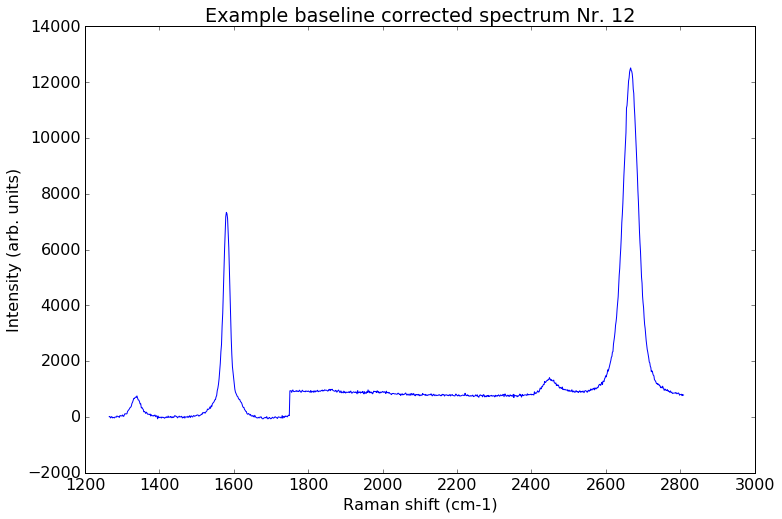

## Example baseline

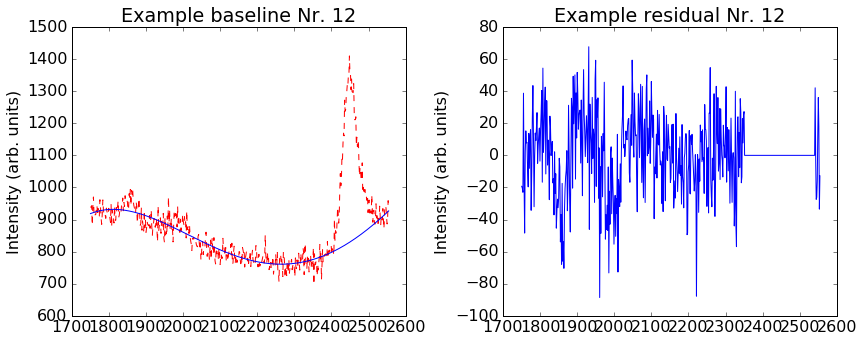

## Example for corrected spectrum

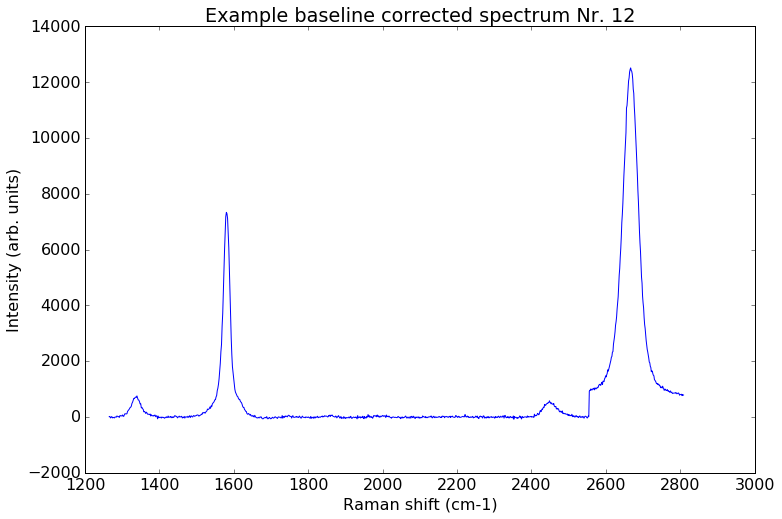

## Example baseline

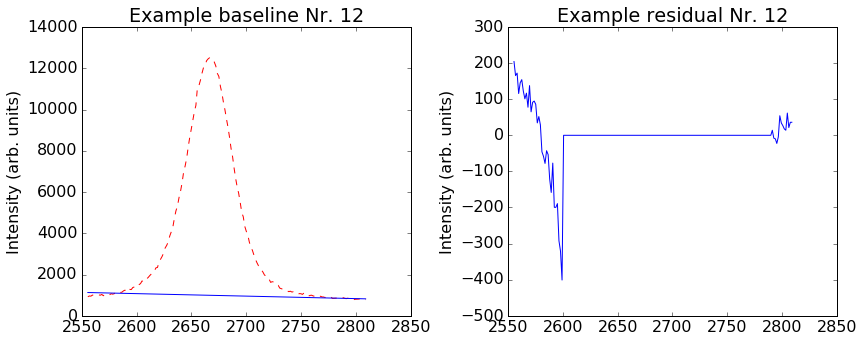

## Example for corrected spectrum

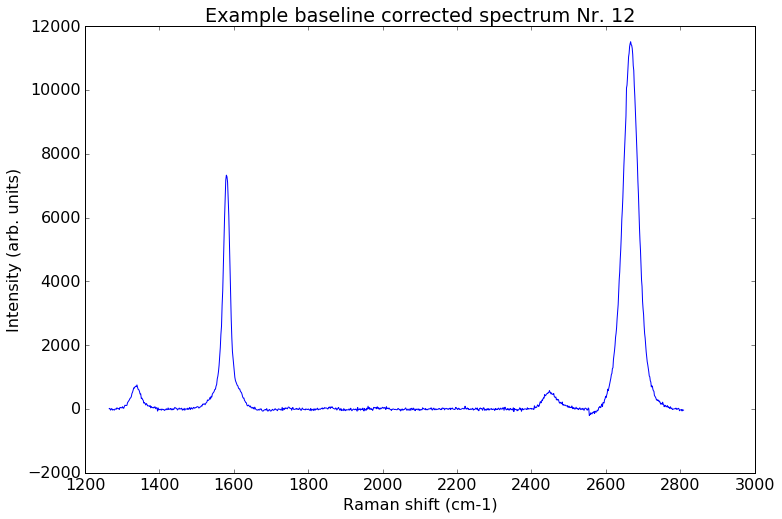

0 spectra were excluded from 121 datasets
121 datasets left for fitting
--- Fitting datasets started  Tue, 20 Sep 2016 10:09:16 +0000
--- Fit completed in 23.319999933242798 seconds ---


In [11]:
#we first read the data
DATASET = Dataset(task=TASK)

#next, we subtract a polynomial baseline of order given in TASK['baselineorder]
#and we sort out spectra with a too low signal to noise level
DATASET.subtractMultiBaseline(baselineParts=BASELINE, exampleSpec=12)

DATASET.filterDatasetBySNR()

#finally we build and fit the model
FIT = MultiPseudoVoigtModel(DATASET, weights=DATASET.weights['peaks'])
FIT.runFit()

In [12]:
#build the graphene specific evaluations from the array of fit results
RESULTS = GrapheneModelResults(FIT.fitResults, DATASET)

## Example fit

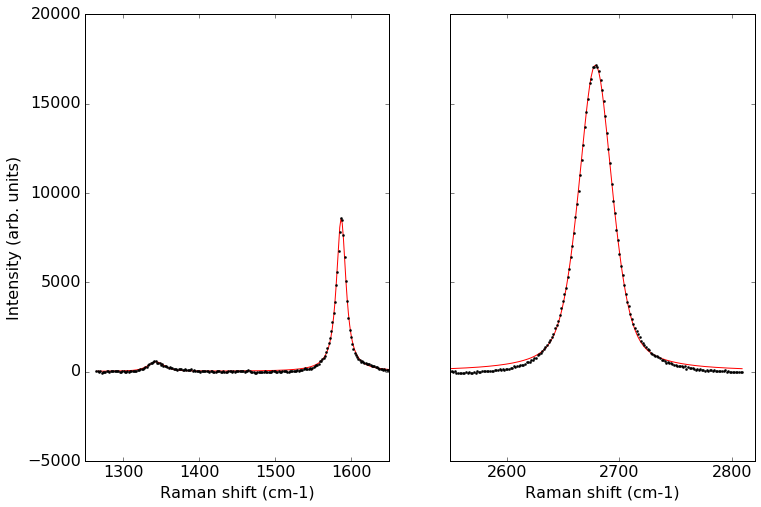

[[Model]]
    ((Model(pvoigt, prefix='D_') + Model(pvoigt, prefix='G_')) + Model(pvoigt, prefix='twoD_'))
[[Fit Statistics]]
    # function evals   = 190
    # data points      = 1014
    # variables        = 16
    chi-square         = 12370144.639
    reduced chi-square = 12394.935
    Akaike info crit   = 9572.866
    Bayesian info crit = 9651.613
[[Variables]]
    D_fraction:        0.74931457 +/- 0        (0.00%) (init= 0.8)
    D_sigma:           13.0313039 +/- 0        (0.00%) (init= 30)
    D_amplitude:       19488.4916 +/- 0        (0.00%) (init= 2.390401e+07)
    D_center:          1343.33505 +/- 0        (0.00%) (init= 1350)
    D_fwhm:            26.0626078 +/- 0        (0.00%)  == '2.0000000*D_sigma'
    D_height:          747.756774 +/- 0        (0.00%)  == 'D_amplitude / D_fwhm'
    G_fraction:        0.94534541 +/- 0        (0.00%) (init= 0.4)
    G_sigma:           7.48229911 +/- 0        (0.00%) (init= 25)
    G_amplitude:       1.9628e+05 +/- 0        (0.00%) (init= 

## 2D peak symmetry

### Normalized squared maximum residuals (NSR)

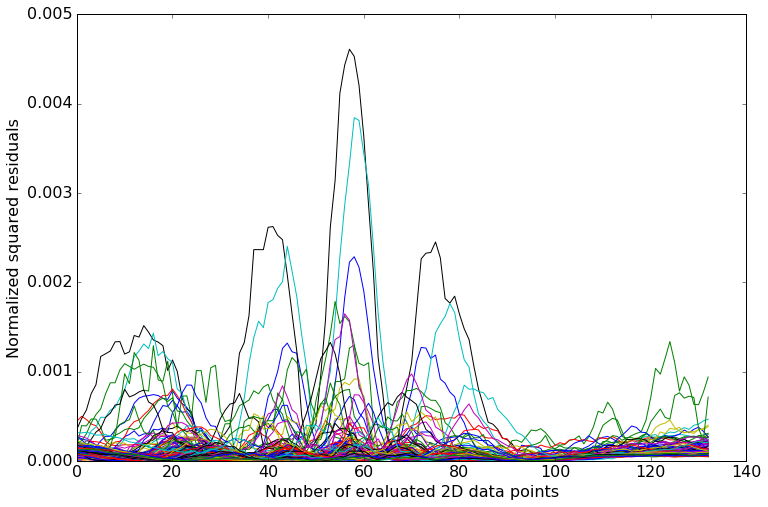

### 2D R2 intervals

Symmetric 2D shapes (R2 > 0.995): 96.69  %
Symmetric 2D shapes (R2 > 0.99): 99.17  %
Symmetric 2D shapes (R2 > 0.98): 100.00  %


### 2D peak R2: 0.999 +/- 0.002

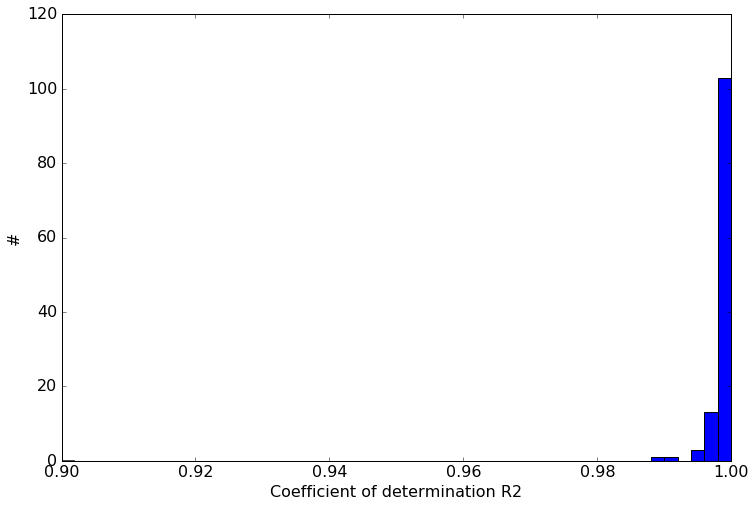

## 2D symmetry outliers

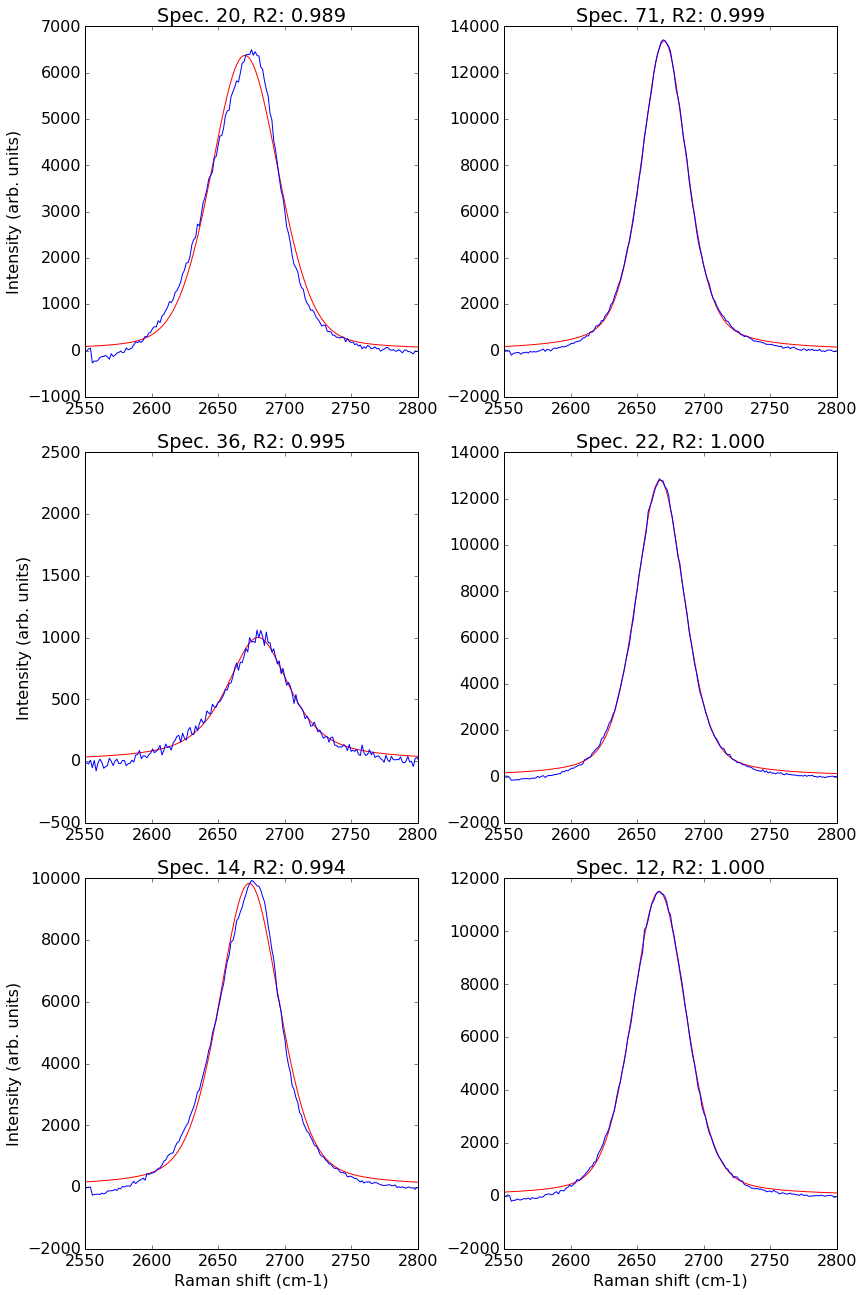

In [13]:
printmd('## Example fit')
exampleFitNumber = 0
RESULTS.plotFit(exampleFitNumber)
print(FIT.fitResults[exampleFitNumber].fit_report())

printmd('## 2D peak symmetry')

printmd('### Normalized squared maximum residuals (NSR)')
RESULTS.get2Dresiduals(plot=True)


printmd('### 2D R2 intervals')
RESULTS.print2Dr2Intervals(0.995)
RESULTS.print2Dr2Intervals(0.99)
RESULTS.print2Dr2Intervals(0.98)
RESULTS.print2Dr2(save=True)

printmd('## 2D symmetry outliers')
RESULTS.plot2DOutliers(3, save=True)

### D/G intervals

D/G < 0.2): 83.47  %
D/G < 0.5): 98.35  %
D/G < 0.8): 98.35  %
D/G < 1.0): 99.17  %


## Peak ratios

D/G ratio by area:  0.140 +/- 0.132
D/G ratio by height:  0.097 +/- 0.123


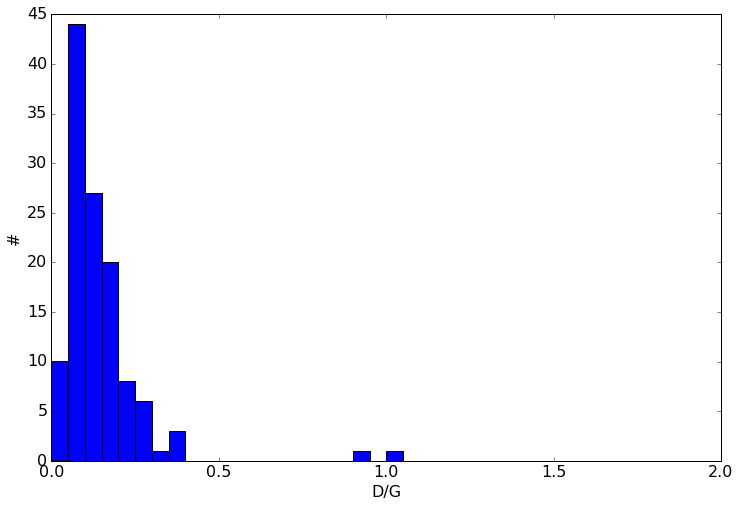

2D/G ratio by area:  3.1686537666  +/-  1.01593769525


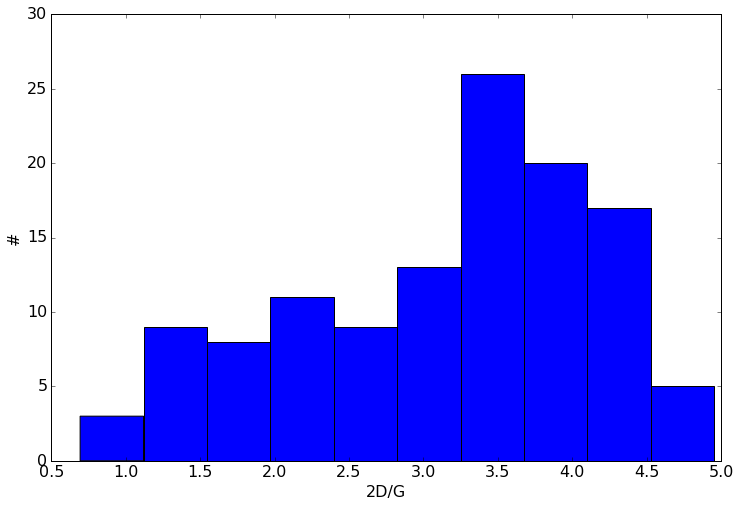

D width:  32.994969243  +/-  8.81030380699
G width:  21.5055051745  +/-  8.35149127006
2D width:  41.4831615573  +/-  6.78512876119


## D/G outliers

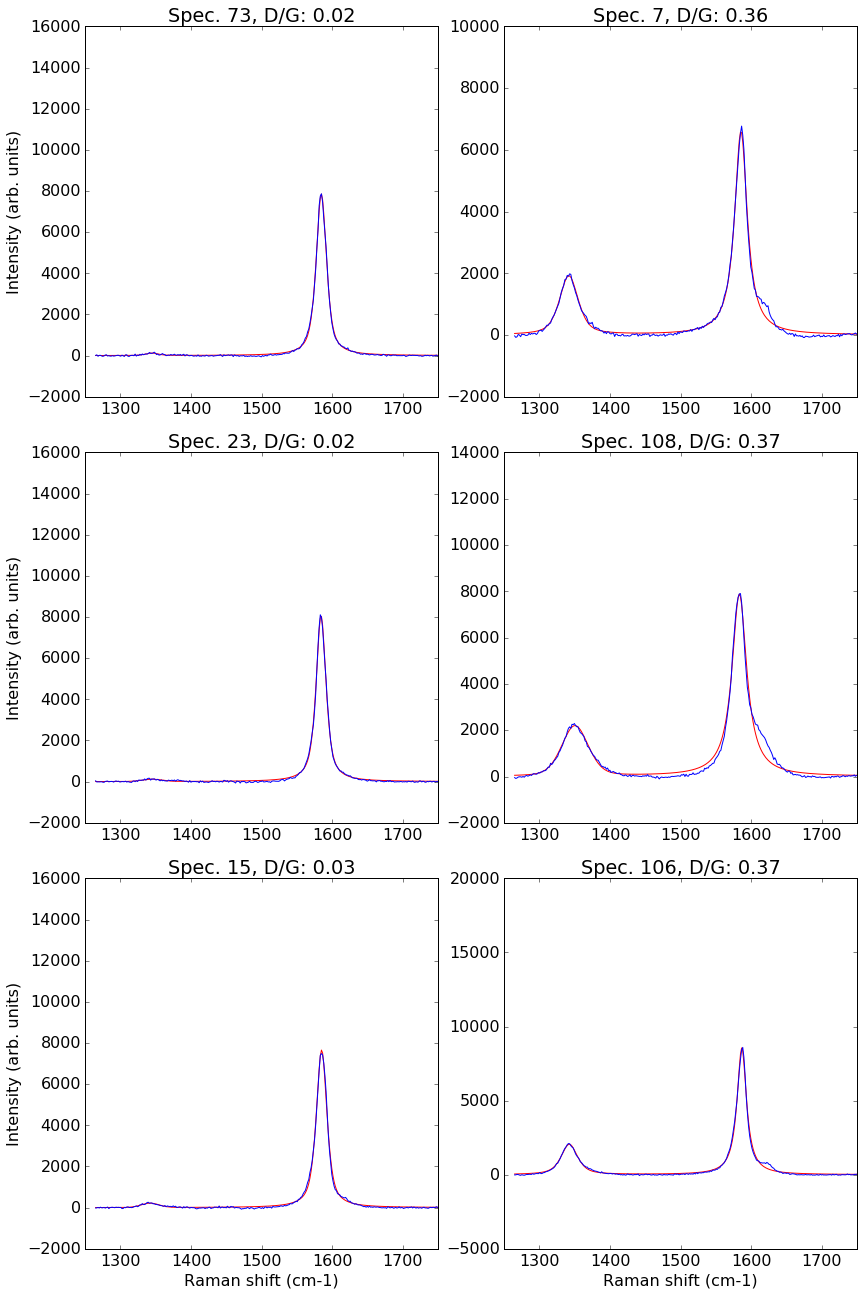

In [14]:
printmd('### D/G intervals')
RESULTS.printDtoGIntervals(0.2)
RESULTS.printDtoGIntervals(0.5)
RESULTS.printDtoGIntervals(0.8)
RESULTS.printDtoGIntervals(1.0)

printmd('## Peak ratios')
RESULTS.printPeakRatios(save=True)
RESULTS.printWidths()

printmd('## D/G outliers')
RESULTS.plotDtoGOutliers(3, save=True)

In [15]:
RESULTS.writeOutput('fitReport')

Evaluation saved as:  C:/Users/hoffmann/Tempo Box/jupyter/raman/examples/CVD_graphene_example_fitReport.csv


In [16]:
printmd('### Evaluation average values')
printmd('Format: D/G +/-   2Db/2Da +/-   2D/G +/-   G width +/-   2D width +/-   G area +/-')
RESULTS.printAvgRes()

### Evaluation average values

Format: D/G +/-   2Db/2Da +/-   2D/G +/-   G width +/-   2D width +/-   G area +/-

0.13995659989 0.132027129589 0.998682923904 0.00151152037547 3.1686537666 1.01593769525 21.5055051745 8.35149127006 41.4831615573 6.78512876119 240515.325225 80275.4275538


In [17]:
%%javascript
IPython.notebook.save_notebook();

<IPython.core.display.Javascript object>

In [18]:
from nbconvert import HTMLExporter
import codecs
import nbformat

time.sleep(1)
exporter = HTMLExporter()
output_notebook = nbformat.read('DtoG-2Dsymetry.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(RESULTS.baseFilename + '.html', 'w', encoding='utf-8').write(output)

Good sciencing everyone!